In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import film
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/home/mmattb/Projects/opto-coproc/data"
sys.path.append(DATA_DIR)
# imported from JNE project
import dataset
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions

In [2]:
# Okay, now a stim data loader...
d, held_out_session_ids = multisession.load_stim_batched(                                                             
    batch_size=7500,                                                               
    window_size=WINDOW_SIZE,                                                               
    session_subdir="torchraw",                                                     
    data_dir=DATA_DIR,
    # held_in_session_ids=["MonkeyG_20150914_Session1_S1", "MonkeyG_20150915_Session2_S1"],
    # held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1", "MonkeyG_20150917_Session1_M1"],   # 10ms, 10ms, 10ms
    held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1"],
    # held_in_session_ids=["MonkeyG_20150925_Session2_S1"],
    # held_in_session_ids=[
    #     "MonkeyG_20150914_Session1_S1",
    #     "MonkeyG_20150915_Session3_S1",
    #     "MonkeyG_20150915_Session5_S1",
    #     "MonkeyG_20150916_Session4_S1",
    #     "MonkeyG_20150917_Session1_M1",
    #     "MonkeyG_20150917_Session1_S1",
    #     "MonkeyG_20150917_Session2_M1",
    #     "MonkeyG_20150917_Session2_S1",
    #     "MonkeyG_20150921_Session3_S1",
    #     "MonkeyG_20150921_Session5_S1",
    #     "MonkeyG_20150922_Session1_S1",
    #     "MonkeyG_20150922_Session2_S1",
    #     "MonkeyG_20150925_Session1_S1",
    #     "MonkeyG_20150925_Session2_S1",
    #     "MonkeyJ_20160426_Session2_S1",
    #     "MonkeyJ_20160426_Session3_S1",
    #     "MonkeyJ_20160428_Session3_S1",
    #     "MonkeyJ_20160429_Session1_S1",
    #     "MonkeyJ_20160502_Session1_S1",
    #     "MonkeyJ_20160624_Session3_S1",
    #     "MonkeyJ_20160625_Session4_S1",
    #     "MonkeyJ_20160625_Session5_S1",
    #     "MonkeyJ_20160627_Session1_S1",
    #     "MonkeyJ_20160630_Session3_S1",
    #     "MonkeyJ_20160702_Session2_S1",
    # ],
    num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [3]:
b = next(iter(data_train))
k = list(b.keys())
k0 = k[0]


b = next(iter(data_train))[k0]

print(f"per session batch size: {b[0].shape[0]}")

per session batch size: 3750


In [4]:
# Customize cfg here...
# Now build...

# At 30 sessions we have fewer examples per session, so AE lrs need to go down. Noisier gradients.
# cfg.ae.training.optim.lr = 1e-5
# cfg.ae.training.coadapt = False
# cfg.training.grad_clip = 2.0
# cfg.tbfm.module.use_film_bases = True
cfg.training.epochs = 12001

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)


Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [ ]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=cfg.training.epochs)


---- 0 1.4129701852798462 1.0921462774276733 -0.4256719723343849 -0.16627010703086853
---- 1000 0.4891933798789978 0.42976921796798706 0.500880777835846 0.5336199402809143
---- 2000 0.4739046096801758 0.4032156765460968 0.5157134085893631 0.5630991458892822
fh Parameter containing:
tensor([[ 0.0349, -0.0502, -0.0451,  ..., -0.0720, -0.1163, -0.1631],
        [ 0.1933,  0.1535, -0.0500,  ...,  0.2062,  0.0340, -0.2797],
        [-0.2932, -0.0696,  0.2111,  ..., -0.1082,  0.0761,  0.1625],
        ...,
        [ 0.2200,  0.0825, -0.2406,  ...,  0.2109, -0.1684, -0.0545],
        [ 0.0099,  0.0810,  0.1670,  ..., -0.1398,  0.1283,  0.1647],
        [ 0.0972, -0.0328, -0.1738,  ...,  0.2010, -0.0683, -0.2442]],
       device='cuda:0', requires_grad=True)
fe tensor([-0.7914, -0.8434,  2.8202, -1.1366, -1.6284, -1.6381,  0.0951, -1.5484,
        -1.4263, -0.3114,  1.7363, -0.1567,  0.1342, -1.4406,  2.5402,  0.8778,
        -1.5241,  0.4043, -0.7092,  0.5531,  0.9899, -1.3252, -0.3830,  0.80

ipdb>  mm = model.model.instances["MonkeyG_20150925_Session2_S1"]
ipdb>  print(mm.prev_bases.grad)


<stdin>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)


None


ipdb>  mm.bases.prev_hidden.grad


*** AttributeError: 'Bases' object has no attribute 'prev_hidden'


ipdb>  mm.bases._last_hidden.grad


*** AttributeError: 'NoneType' object has no attribute 'grad'


ipdb>  mm.bases.last_hidden.grad
ipdb>  print(mm.bases.last_hidden.grad)


None


ipdb>  print(mm.prev_basis_weights.grad)


None


ipdb>  print(mm.prev_basis_weights.requires_grad)


True


In [18]:
print(results["final_test_r2s"])
print(results['final_test_r2s']["MonkeyG_20150925_Session2_S1"])

{'MonkeyG_20150925_Session2_S1': tensor(0.6908, device='cuda:0'), 'MonkeyJ_20160630_Session3_S1': tensor(0.4565, device='cuda:0')}
tensor(0.6908, device='cuda:0')


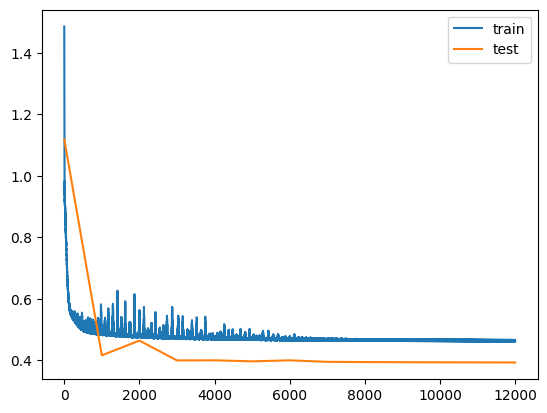

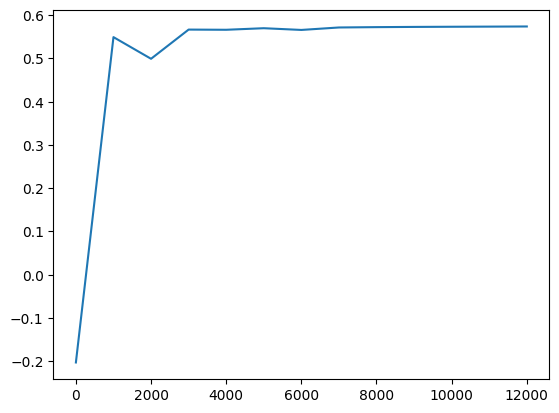

In [19]:
plt.plot(results["train_losses"], label="train")

tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
plt.plot(tx, tl, label="test")
plt.legend()
plt.show()

tr = [t[1] for t in results['test_r2s']]
plt.plot(tx, tr)
plt.show()

In [20]:
print(embeddings_rest['MonkeyG_20150925_Session2_S1'])
print(embeddings_rest['MonkeyJ_20160630_Session3_S1'])
print(embeddings_stim['MonkeyG_20150925_Session2_S1'])
print(embeddings_stim['MonkeyJ_20160630_Session3_S1'])

tensor([0.3163, 0.3348, 0.3501], device='cuda:0')
tensor([0.2292, 0.2772, 0.3633], device='cuda:0')
tensor([ 0.0032, -0.0038,  0.0033,  0.0037, -0.0035, -0.0035, -0.0038, -0.0033,
         0.0043,  0.0035,  0.0033,  0.0035,  0.0033, -0.0028, -0.0037, -0.0029,
        -0.0039, -0.0037,  0.0033, -0.0038, -0.0027, -0.0030, -0.0036,  0.0030,
        -0.0026,  0.0023,  0.0031, -0.0030,  0.0035], device='cuda:0')
tensor([ 0.0013, -0.0017,  0.0014,  0.0017, -0.0016, -0.0015, -0.0017, -0.0014,
         0.0020,  0.0015,  0.0015,  0.0016,  0.0014, -0.0011, -0.0016, -0.0012,
        -0.0017, -0.0016,  0.0014, -0.0017, -0.0011, -0.0013, -0.0016,  0.0013,
        -0.0011,  0.0009,  0.0013, -0.0013,  0.0015], device='cuda:0')


tensor([-0.5790, -0.5846, -0.5959, -0.6056, -0.6324, -0.6288, -0.6479, -0.6459,
        -0.6426, -0.6604], device='cuda:0')
------
------
tensor([-0.5790, -0.5846, -0.5959, -0.6056, -0.6324, -0.6288, -0.6479, -0.6459,
        -0.6426, -0.6604], device='cuda:0')


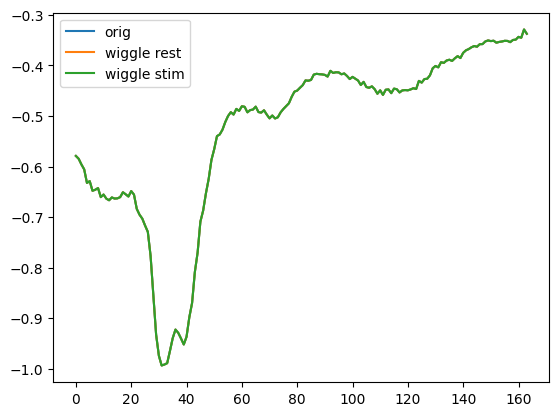

In [21]:
# see how much predictions change as I tweak embeddings

def wiggle(stuff):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.05)

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)
    plt.plot(preds['MonkeyG_20150925_Session2_S1'][0][:, ch].detach().cpu(), label="orig")
    print(preds['MonkeyG_20150925_Session2_S1'][0][:, ch][:10])
    print("------")
    
    preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    plt.plot(preds['MonkeyG_20150925_Session2_S1'][0][:, ch].detach().cpu(), label="wiggle rest")
    print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(embeddings_stim))
    plt.plot(preds['MonkeyG_20150925_Session2_S1'][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds['MonkeyG_20150925_Session2_S1'][0][:, ch][:10])
plt.legend()
plt.show()

In [17]:
print(ms.model.instances['MonkeyG_20150925_Session2_S1'].prev_bases[0])

tensor([[-1.6950, -1.6841, -1.5680,  ...,  1.0476, -1.6124,  1.8581],
        [ 1.5737,  0.8381,  0.6144,  ...,  0.4595, -1.4544, -0.4424],
        [ 1.9009,  0.6420,  0.6892,  ...,  1.8129,  1.1658,  1.8373],
        ...,
        [ 1.4457, -0.6197,  1.1864,  ...,  0.7964, -0.7746,  1.1812],
        [-0.5792, -0.3554,  1.8601,  ..., -0.8813, -0.4835,  1.3485],
        [ 1.0957, -1.2948,  1.0056,  ...,  0.2971, -0.7856,  0.9564]],
       device='cuda:0')


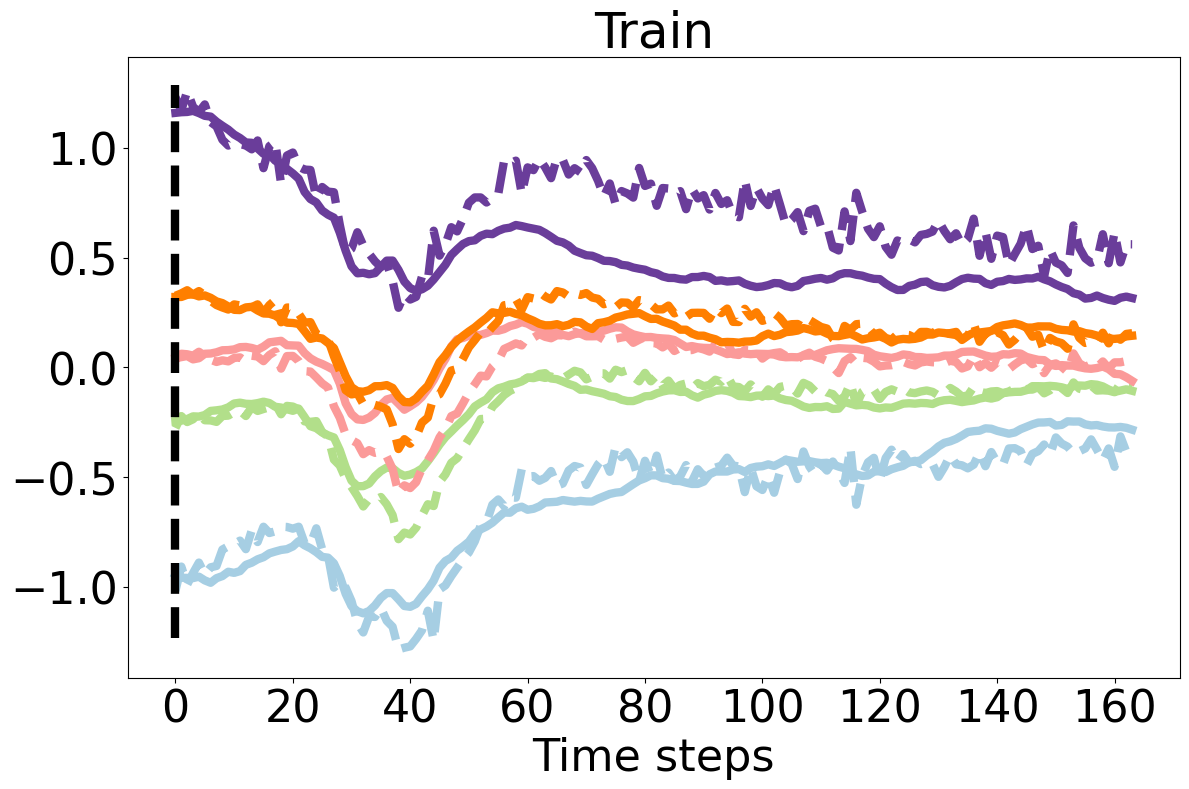

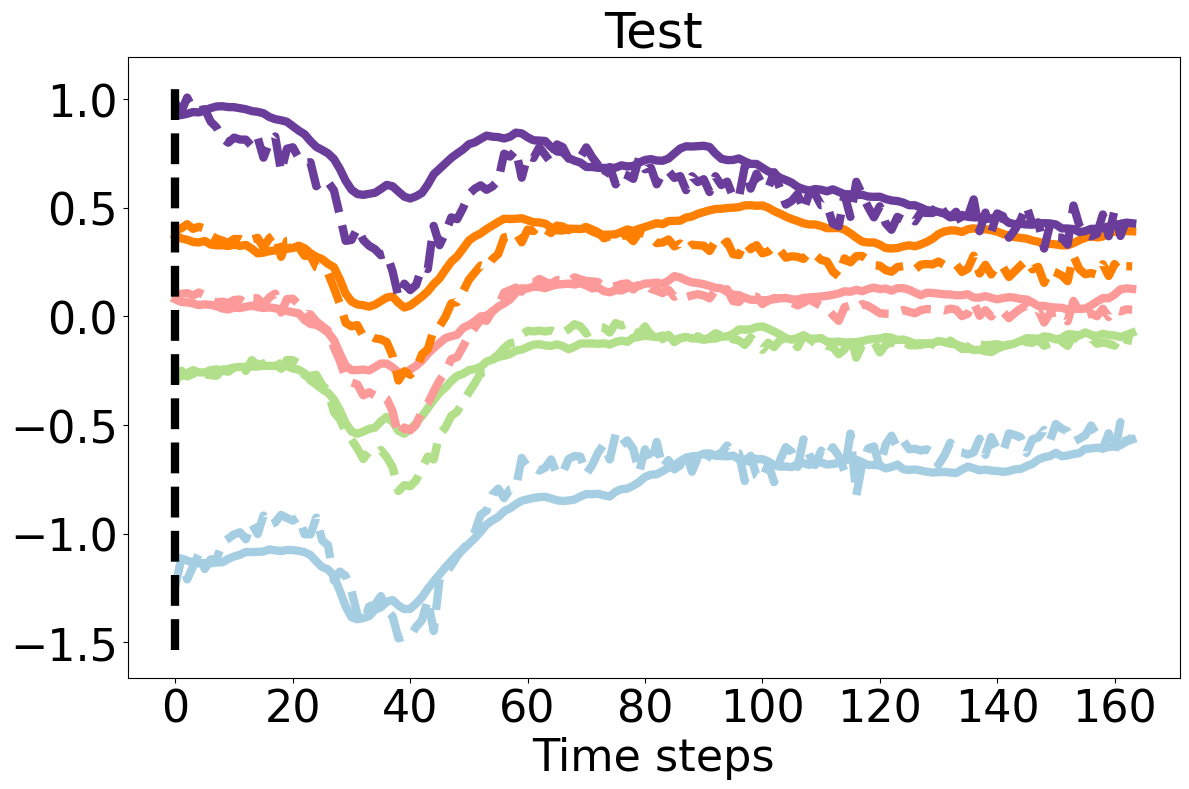

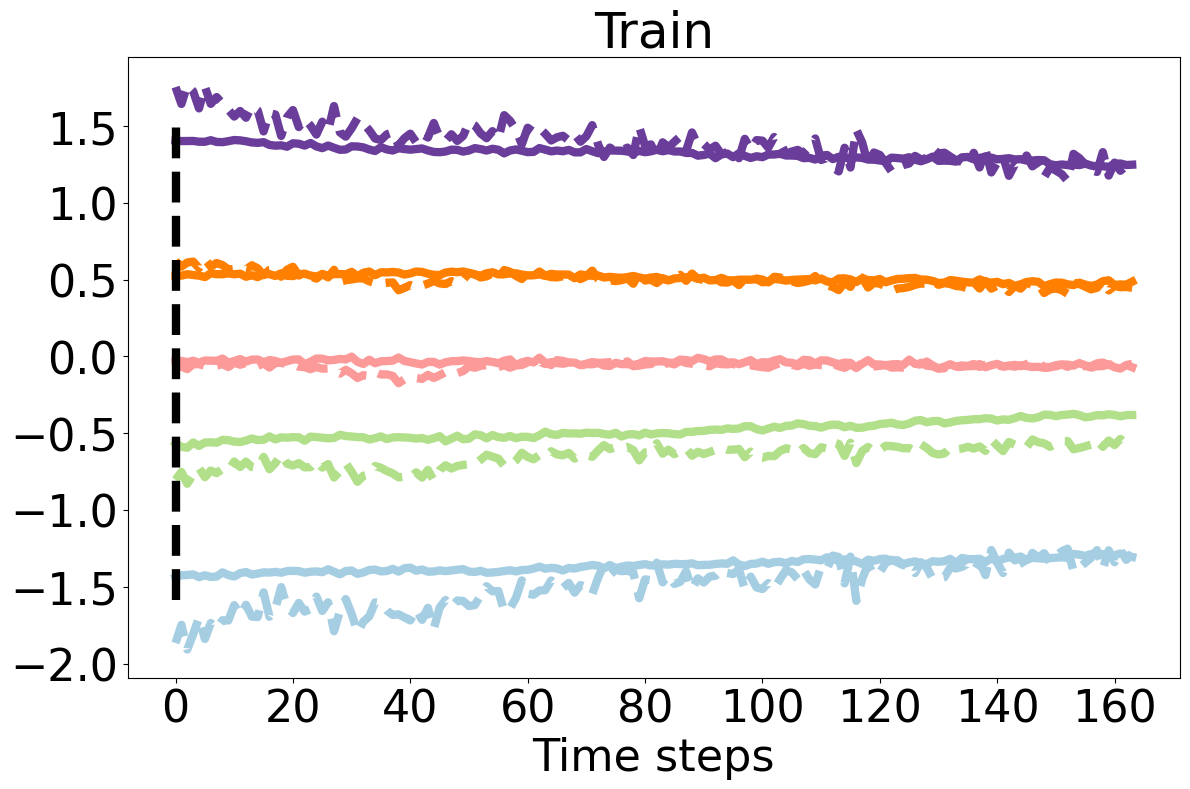

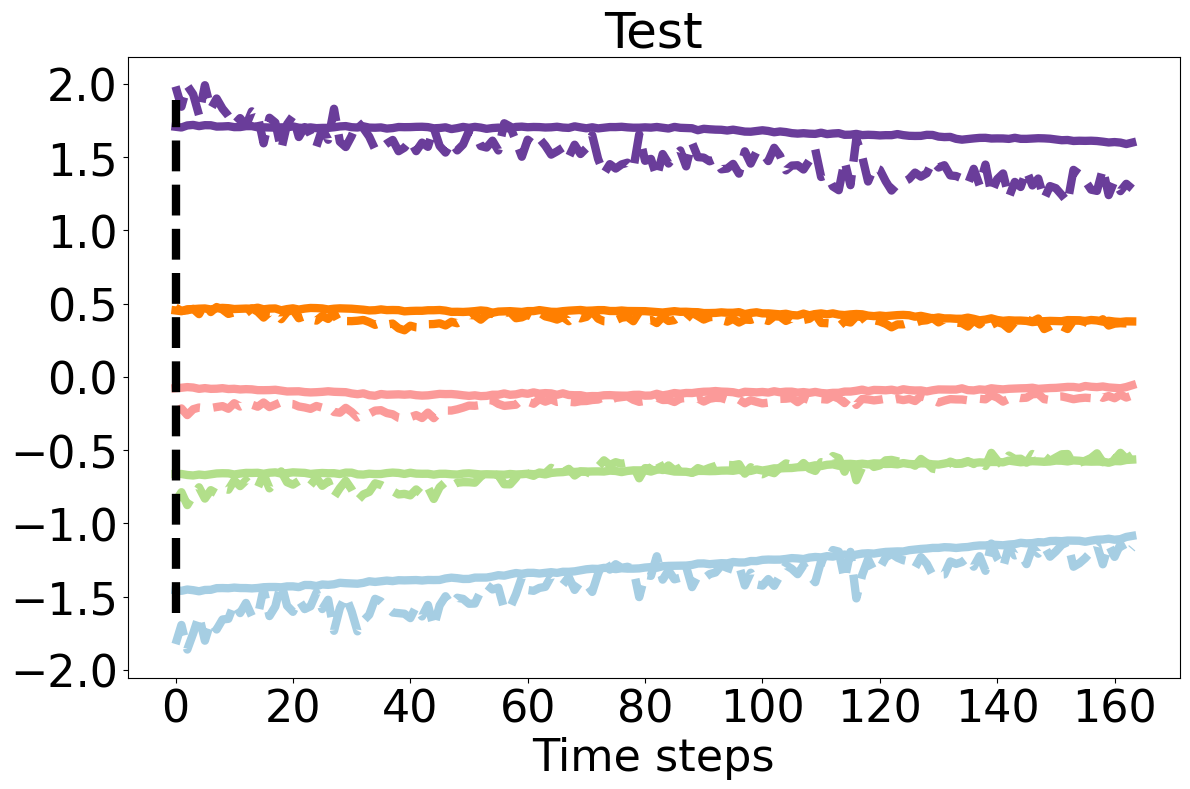

In [12]:
def graph_for_sid(sid, results, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    # y_hat_mean = torch.mean(y_hats, dim=0)
    # y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    # y_mean = torch.mean(y, dim=0)
    # y_test_mean = torch.mean(y_test, dim=0)
    
    # bidx = 1000
    
    # plt.plot(y_hat_test_mean[:, cidx], label="hat")
    # plt.plot(y_test_mean[RUNWAY:, cidx], label="y")
    # plt.legend()
    # plt.show()
    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)

graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)
graph_for_sid('MonkeyJ_20160630_Session3_S1', results)

In [ ]:
# Try:
# * regweight = 0.01, 0.02, 0.05, 0.07, 0.1
# * num bases = 10, 12, 15, 17, 20
# * latent dim = 20, 30, 50, 70
# * grad_clip = (1.0, 10.0)

for regweight in (0.01, 0.05, 0.07):
    for num_bases in (12, 15, 17, 20):
        for latent_dim in (50, 70):
            for grad_clip in (10.0, 1000):
                print("---------------", regweight, num_bases, latent_dim, grad_clip)
    
                cfg.tbfm.training.lambda_fro = regweight
                cfg.tbfm.module.num_bases = num_bases
                cfg.latent_dim = latent_dim
                cfg.tbfm.module.use_film_bases = True
                cfg.ae.training.coadapt = True
    
                ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
                model_optims = multisession.get_optims(cfg, ms)
                
                embeddings_stim, results = multisession.train_from_cfg(
                    cfg,
                    ms,
                    data_train,
                    model_optims,
                    embeddings_rest,
                    data_test=data_test,
                    test_interval=1000,
                    epochs=12001,
                    grad_clip=grad_clip
                    )
                torch.save(results, f"res_{regweight}_{num_bases}_{latent_dim}_{grad_clip}.torch")

                del model_optims, ms

--------------- 0.01 12 50 10.0
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.5203737020492554 1.3181246519088745 -0.5778152545293173 -0.3565210700035095
---- 1000 0.5794039368629456 0.5404284596443176 0.3935075600941976 0.44591158628463745
---- 2000 0.5780431032180786 0.5375792980194092 0.39547404150168103 0.44859790802001953
---- 3000 0.5585286617279053 0.5327796339988708 0.41441672543684643 0.45335668325424194
---- 4000 0.5517772436141968 0.5317503809928894 0.42117766042550403 0.45428285002708435
---- 5000 0.5482078790664673 0.5320929288864136 0.42486423750718433 0.4538620710372925
---- 6000 0.5419892072677612 0.5319070219993591 0.43104944626490277 0.45406755805015564
---- 7000 0.5433573126792908 0.5335626006126404 0.42990849912166595 0.45237135887145996
---- 8000 0.5377671718597412 0.5336729884147644 0.4354857951402664 0.45219939947128296
---- 9000 0.5357591509819031 0.5341219305992126 0.4374978293975194 0.4516174197

In [5]:
d = "."
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

for rr in res[-10:]:
    print(rr)

# (0.4557589888572693, './res_0.07_17_70_10.0.torch')
# (0.4561246633529663, './res_0.05_12_50_10.0.torch')
# (0.45635348558425903, './res_0.01_17_70_10.0.torch')
# (0.4564235210418701, './res_0.07_17_70_1000.torch')
# (0.4569217562675476, './res_0.05_17_50_10.0.torch')
# (0.45701655745506287, './res_0.05_17_50_1000.torch')
# (0.4574051797389984, './res_0.05_20_70_1000.torch')
# (0.4576779007911682, './res_0.05_15_50_1000.torch')
# (0.45774632692337036, './res_0.05_15_70_1000.torch')
# (0.4579020142555237, './res_0.05_17_70_10.0.torch')

# Fro 0.05
# num_bases 17
# latent dim 70
# clip_grad None

(0.4557589888572693, './res_0.07_17_70_10.0.torch')
(0.4561246633529663, './res_0.05_12_50_10.0.torch')
(0.45635348558425903, './res_0.01_17_70_10.0.torch')
(0.4564235210418701, './res_0.07_17_70_1000.torch')
(0.4569217562675476, './res_0.05_17_50_10.0.torch')
(0.45701655745506287, './res_0.05_17_50_1000.torch')
(0.4574051797389984, './res_0.05_20_70_1000.torch')
(0.4576779007911682, './res_0.05_15_50_1000.torch')
(0.45774632692337036, './res_0.05_15_70_1000.torch')
(0.4579020142555237, './res_0.05_17_70_10.0.torch')


In [7]:
cfg.tbfm.training.lambda_fro = 0.05
cfg.tbfm.module.num_bases = 17
cfg.latent_dim = 70
cfg.tbfm.module.use_film_bases = True
cfg.ae.training.coadapt = True

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=15001,
    grad_clip=grad_clip
    )
multisession.save_model(ms, "session3.torch", tbfm_only=True)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.7282235622406006 1.4277710914611816 -0.7834978898366293 -0.4688534438610077
---- 1000 0.5889748334884644 0.5492038726806641 0.38332296907901764 0.43664056062698364
---- 2000 0.578731119632721 0.5410599708557129 0.3937474737564723 0.444960355758667
---- 3000 0.6143547296524048 0.5776938199996948 0.36004498104254407 0.40702182054519653
---- 4000 0.6094337701797485 0.551339864730835 0.36514731248219806 0.43505871295928955
---- 5000 0.568423867225647 0.5330778956413269 0.4050182302792867 0.4534160792827606
---- 6000 0.5660974383354187 0.535632848739624 0.4071046511332194 0.45071160793304443
---- 7000 0.562555193901062 0.5340944528579712 0.4104987432559331 0.45200562477111816
---- 8000 0.5612501502037048 0.5329346060752869 0.41190898418426514 0.45326513051986694
---- 9000 0.5625225901603699 0.5330714583396912 0.4108348786830902 0.4528921842575073
---- 10000 0.5645100474357605 0.53

In [9]:
print(results["final_test_r2s"])

{'MonkeyG_20150917_Session1_M1': tensor(0.2306, device='cuda:0'), 'MonkeyG_20150925_Session2_S1': tensor(0.6888, device='cuda:0'), 'MonkeyJ_20160630_Session3_S1': tensor(0.4499, device='cuda:0')}
